# Unilever Data Science POC Use Case
**Problem Definition:** One of our brands is going through some major changes in business execution plans and
will like to know.

1. What are the major drivers for sales(EQ)?
2. Knowing the drivers, how accurately we can predict future sales for next 6 periods?

## Dictionary
1. Day                                   
2. EQ                                    
3. Social_Search_Impressions             
4. Social_Search_Working_cost            
5. Digital_Impressions                   
6. Digital_Working_cost                 
7. Print_Impressions.Ads40               
8. Print_Working_Cost.Ads50              
9. OOH_Impressions                   
10. OOH_Working_Cost                    
11. SOS_pct                             
12. Digital_Impressions_pct               
13. CCFOT                                    
14. Median_Temp                              
15. Median_Rainfall                      
16. Fuel_Price                            
17. Inflation                           
18. Trade_Invest                        
19. Brand_Equity                          
20. Avg_EQ_Price                           
21. Any_Promo_pct_ACV                   
22. Any_Feat_pct_ACV                     
23. Any_Disp_pct_ACV                     
24. EQ_Base_Price                          
25. Est_ACV_Selling                       
26. pct_ACV                               
27. Avg_no_of_Items                       
28. pct_PromoMarketDollars_Category       
29. RPI_Category                           
30. Magazine_Impressions_pct               
31. TV_GRP                                
32. Competitor1_RPI                       
33. Competitor2_RPI                      
34. Competitor3_RPI                         
35. Competitor4_RPI                      
36. EQ_Category                           
37. EQ_Subcategory                        
38. pct_PromoMarketDollars_Subcategory     
39. RPI_Subcategory                      

# Import Libraries

In [4]:
import gc
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib

from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold

# Importing all models
# Regression
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso, BayesianRidge, HuberRegressor, LassoLars, Huber, Lars
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

import lightgbm as lgb
import xgboost as xgb
import catboost as cat

import warnings
warnings.simplefilter('ignore')

from catboost import Pool
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
plt.style.use("fivethirtyeight")

pd.options.display.max_columns = 50

## Metric Function

- **Mean absolute percentage error (MAPE)** is a measure of prediction accuracy of a forecasting method in statistics.

In [20]:
def mape(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Import the dataset

In [22]:
train = pd.read_csv("train_period_wise_mean_aggregated.csv")
test = pd.read_csv("data/test.csv")

train.shape, test.shape

((429, 39), (39, 39))

In [23]:
train.head()

,Period,EQ,Social_Search_Impressions,Social_Search_Working_cost,Digital_Impressions,Digital_Working_cost,Print_Impressions.Ads40,Print_Working_Cost.Ads50,OOH_Impressions,OOH_Working_Cost,SOS_pct,Digital_Impressions_pct,CCFOT,Median_Temp,Median_Rainfall,Fuel_Price,Inflation,Trade_Invest,Brand_Equity,Avg_EQ_Price,Any_Promo_pct_ACV,Any_Feat_pct_ACV,Any_Disp_pct_ACV,EQ_Base_Price,Est_ACV_Selling,pct_ACV,Avg_no_of_Items,pct_PromoMarketDollars_Category,RPI_Category,Magazine_Impressions_pct,TV_GRP,Competitor1_RPI,Competitor2_RPI,Competitor3_RPI,Competitor4_RPI,EQ_Category,EQ_Subcategory,pct_PromoMarketDollars_Subcategory,RPI_Subcategory
0,0,691.138041,1.831008e+07,76215.888889,6.494467e+06,199228.666667,203552.703704,104216.296296,3.699929e+08,1.921175e+06,21.703704,24.962963,61.259259,53.370370,0.488584,8.575519,0.061788,5382.851852,43.212593,51.765185,8.114481,3.686296,2.285333,1.528556,5.404393e+08,29.072963,2.606596,0.244774,39.857963,50.817037,30.188148,107.590741,38.753333,45.574074,70.507778,6.970413e+06,517645.074074,0.234111,39.302963
1,1,242.226804,1.487507e+07,59077.214286,6.597846e+06,197114.178571,208935.821429,100833.821429,4.492428e+08,1.810302e+06,28.464286,22.892857,50.535714,59.178571,0.526225,8.464893,0.064497,5645.857143,43.112143,51.811071,8.214607,3.753571,2.325464,1.534536,6.405926e+08,28.138214,2.562546,0.200081,40.319321,52.327857,28.475000,104.968214,37.218571,46.160000,70.298929,7.376125e+06,519026.892857,0.213271,40.535357
2,2,1120.787428,2.384695e+07,71004.642857,6.026243e+06,215623.464286,202017.750000,117552.285714,5.651369e+08,2.013479e+06,25.250000,23.535714,63.464286,56.785714,0.559766,8.483857,0.066658,5422.892857,43.285000,52.789643,7.516286,4.235357,2.692107,1.570821,5.995501e+08,27.786071,2.593829,0.277661,41.102893,52.943929,30.968929,104.961071,39.166786,46.230714,70.085357,6.331048e+06,490450.000000,0.240179,41.646071
3,3,595.708310,1.850887e+07,64412.142857,7.237925e+06,194743.178571,212753.750000,111015.464286,4.321768e+08,1.976103e+06,29.035714,26.607143,48.071429,51.107143,0.530616,8.636036,0.061298,5707.607143,43.230714,50.071429,8.407929,3.844286,1.970393,1.558214,5.895530e+08,28.638929,2.590339,0.219184,40.678500,48.036786,29.393929,109.218929,38.281071,46.594286,69.828214,6.213333e+06,558683.035714,0.223539,41.582500
4,4,1268.682396,2.048137e+07,63095.892857,5.598245e+06,198530.928571,192220.142857,103754.428571,4.760899e+08,2.056608e+06,23.750000,23.107143,63.321429,54.142857,0.565498,8.485536,0.083535,5249.035714,43.121071,51.973929,8.974107,3.777500,2.486071,1.558214,5.829991e+08,27.308214,2.548482,0.208084,41.325143,50.014643,28.013214,106.318929,38.601071,46.153214,70.849643,6.574164e+06,590783.535714,0.223100,38.497143


In [24]:
train.tail()

,Period,EQ,Social_Search_Impressions,Social_Search_Working_cost,Digital_Impressions,Digital_Working_cost,Print_Impressions.Ads40,Print_Working_Cost.Ads50,OOH_Impressions,OOH_Working_Cost,SOS_pct,Digital_Impressions_pct,CCFOT,Median_Temp,Median_Rainfall,Fuel_Price,Inflation,Trade_Invest,Brand_Equity,Avg_EQ_Price,Any_Promo_pct_ACV,Any_Feat_pct_ACV,Any_Disp_pct_ACV,EQ_Base_Price,Est_ACV_Selling,pct_ACV,Avg_no_of_Items,pct_PromoMarketDollars_Category,RPI_Category,Magazine_Impressions_pct,TV_GRP,Competitor1_RPI,Competitor2_RPI,Competitor3_RPI,Competitor4_RPI,EQ_Category,EQ_Subcategory,pct_PromoMarketDollars_Subcategory,RPI_Subcategory
424,424,587.003890,1.798765e+07,71065.321429,5.852410e+06,180441.250000,188098.892857,84491.750000,4.260000e+08,1.886556e+06,26.785714,27.250000,63.321429,52.750000,0.528923,8.412679,0.073619,4579.642857,43.105357,51.495714,9.087821,4.048929,2.196714,1.537179,6.189417e+08,26.833929,2.570150,0.213511,40.265679,51.006071,30.058571,108.638929,37.500357,46.891071,70.577857,6.250261e+06,556688.428571,0.234289,39.341786
425,425,619.920998,1.940351e+07,61652.464286,6.536257e+06,238546.750000,181150.500000,101793.821429,4.954592e+08,1.726794e+06,21.500000,30.785714,58.678571,57.607143,0.496641,8.487214,0.080355,5019.250000,43.136786,52.078571,9.057286,3.800714,2.254357,1.523571,5.602750e+08,28.899643,2.608189,0.265405,40.317643,49.402143,28.086071,105.581786,39.047857,46.132143,69.017500,6.702076e+06,598008.607143,0.206564,39.237143
426,426,548.275433,1.921742e+07,64723.500000,6.314241e+06,228744.928571,191112.892857,101472.214286,4.498218e+08,1.950923e+06,24.571429,29.535714,63.714286,58.357143,0.524182,8.465929,0.058057,5041.357143,43.202857,51.512500,8.824821,3.492500,2.165179,1.550107,5.493603e+08,30.552500,2.494532,0.239678,40.383607,44.733929,29.546786,107.046786,37.681429,46.411071,70.569286,6.111488e+06,545254.821429,0.213507,40.694286
427,427,371.869570,1.954088e+07,56628.142857,6.189946e+06,236645.071429,191678.500000,82416.821429,5.065050e+08,1.958916e+06,27.535714,32.250000,49.178571,54.750000,0.427763,8.617893,0.076377,5569.678571,43.210714,51.420714,8.683643,4.171786,2.104750,1.536786,5.469179e+08,34.118929,2.645786,0.189067,40.447536,41.892143,25.598214,107.298214,38.085357,46.858214,69.515357,6.611687e+06,587347.035714,0.220318,38.950357
428,428,477.996587,2.353804e+07,70842.882353,6.791396e+06,183648.823529,236882.647059,79170.823529,4.298306e+08,2.101321e+06,22.235294,31.235294,49.823529,47.764706,0.571224,8.376765,0.058643,5426.764706,43.121176,50.520000,8.007765,3.507647,2.442353,1.541529,4.550993e+08,32.219412,2.541829,0.228400,39.888706,52.375294,31.307647,107.560588,38.481765,45.570588,71.159412,6.835903e+06,519217.823529,0.158371,41.030000


## Mapping the Period Feature of test to align with train dataset.
1. Train data is not provided with year feature, but test data contains the year in the Period feature.
2. To resolve this year conflict, we have assigned the Period number, according to the training data.

In [26]:
# Map the Period Number with the train Dataset
test['Period'] = test['Period'].apply(lambda x: int(x.split(":")[1]) + 428)
test.head()

,Period,EQ,Social_Search_Impressions,Social_Search_Working_cost,Digital_Impressions,Digital_Working_cost,Print_Impressions.Ads40,Print_Working_Cost.Ads50,OOH_Impressions,OOH_Working_Cost,SOS_pct,Digital_Impressions_pct,CCFOT,Median_Temp,Median_Rainfall,Fuel_Price,Inflation,Trade_Invest,Brand_Equity,Avg_EQ_Price,Any_Promo_pct_ACV,Any_Feat_pct_ACV,Any_Disp_pct_ACV,EQ_Base_Price,Est_ACV_Selling,pct_ACV,Avg_no_of_Items,pct_PromoMarketDollars_Category,RPI_Category,Magazine_Impressions_pct,TV_GRP,Competitor1_RPI,Competitor2_RPI,Competitor3_RPI,Competitor4_RPI,EQ_Category,EQ_Subcategory,pct_PromoMarketDollars_Subcategory,RPI_Subcategory
0,429,504.784933,2019283.0,5493.0,37148.2,2045.282,0.000012,0.000012,1.203045e+09,2220633.0,7.446883,16.0,100.0,32.950,0.5150,8.226,0.013258,42744.256840,42.410000,49.091447,9.691794,2.87,1.688896,1.427532,8696587915,39.441025,2.611782,0.0339,35.817030,27.702433,21.300,97.173365,35.557371,44.502717,63.377268,1728388.673,331927.5394,0.162732,40.560563
1,430,490.226477,4564738.0,12938.0,50886.8,2370.584,0.000014,0.000015,1.944356e+09,469895.0,11.677082,5.0,87.5,34.625,0.2700,7.473,0.009938,36290.439557,42.410000,49.057612,9.415938,2.87,1.687952,1.442716,8682307085,38.417224,2.522814,0.0391,36.389065,21.432628,12.334,97.850760,37.223072,45.720077,62.731742,1900859.879,334611.3806,0.231650,40.046301
2,431,479.244686,1029384.0,6546.0,253333.2,3180.888,0.000016,0.000017,9.984054e+08,4465061.0,0.102858,46.0,96.0,46.700,0.3900,8.001,0.007832,34852.141656,42.410000,49.367514,5.176684,2.87,1.834440,1.423408,8706897549,36.499442,2.477322,0.0228,36.599984,29.726275,23.213,96.397739,40.800563,41.822953,62.090417,2036436.906,387148.3582,0.125394,40.411115
3,432,489.057428,902938.0,3928.0,3426239.0,13595.398,0.000016,0.000019,3.039816e+09,1031855.0,0.249055,48.0,100.0,49.650,0.3500,8.767,0.010034,24869.558988,43.543571,50.657634,6.088273,2.87,2.444000,1.443401,8660288592,38.135159,2.520409,0.0147,38.201852,30.326275,14.456,98.936519,36.576140,41.578429,63.374358,2113635.013,482489.6740,0.056603,42.213246
4,433,477.031994,1343454.0,28374.0,552197.8,3983.134,0.000016,0.000019,9.622004e+08,2842722.0,13.338804,19.0,100.0,58.100,0.5025,9.277,0.009546,61675.321620,43.790000,50.625777,7.827112,1.87,0.170731,1.473687,8644518558,38.629564,2.497285,0.0219,38.648805,31.702433,25.300,100.509969,36.032016,42.602412,63.291934,2402211.102,629826.6484,0.065059,43.345578


In [27]:
# Features
target = 'EQ'
feat = train.columns.tolist()
feat.remove(target)

len(feat)

38

# Basliner

In [28]:
def baseliner(train, features, target, cv=3, metric=make_scorer(mape, greater_is_better=False)):
    """
    Function for baselining Models which return CV Score, Train Score, Valid Score
    """
    eval_dict = {}
    models = [lgb.LGBMRegressor(), xgb.XGBRegressor(objective="reg:squarederror"), 
              GradientBoostingRegressor(), RandomForestRegressor(), 
              LinearRegression(), DecisionTreeRegressor(), ExtraTreeRegressor(), AdaBoostRegressor(), 
              BaggingRegressor(), ExtraTreesRegressor(), ElasticNet(), Lasso(), Ridge(), SVR(), 
              KNeighborsRegressor()]
    # cat.CatBoostRegressor(verbose=0), 
    print("sklearn Model Name  \t  CV") #    | \t TRN   | \t  VAL
    print("--" * 50)

    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}

        results = cross_val_score(model, train[features], train[target], cv=cv, scoring=metric)
        eval_dict[model_name]['cv'] = results.mean()

        print("%s \t %.4f \t" % (
            model_name[:21], eval_dict[model_name]['cv']))

In [29]:
baseliner(train, feat, target)

sklearn Model Name  	  CV
----------------------------------------------------------------------------------------------------
LGBMRegressor 	 -26.3897 	
XGBRegressor 	 -27.0539 	
GradientBoostingRegre 	 -26.0887 	
RandomForestRegressor 	 -26.6212 	
LinearRegression 	 -23.2615 	
DecisionTreeRegressor 	 -36.2545 	
ExtraTreeRegressor 	 -36.6865 	
AdaBoostRegressor 	 -26.8485 	
BaggingRegressor 	 -27.4602 	
ExtraTreesRegressor 	 -26.6752 	
ElasticNet 	 -28.7060 	
Lasso 	 -25.9412 	
Ridge 	 -27.0727 	
SVR 	 -30.4997 	
KNeighborsRegressor 	 -35.8210 	


## LGB Model

In [30]:
# Metric Function for LGB Model
def mape_lgb(y_hat, data):
    """
    MAPE can be given in feval: of lgb param with eval_result
    :param y_hat: y_pred
    :param data:  lgb.Dataset
    :return: rmsle(), greater_is_better
    """
    y_true = data.get_label()
    return 'MAPE', mape(y_true, y_hat), False

In [56]:
def splitter(train, features, target, ts=False):
    if ts:
        trainX, validX, trainY, validY = train_test_split(train[features],
                                                          train[target], test_size=0.3,
                                                          random_state=13, shuffle=False)
    else:
        trainX, validX, trainY, validY = train_test_split(train[features],
                                                      train[target], test_size=0.3,
                                                      random_state=13)
    return trainX, validX, trainY, validY

def lgb_model(train, features, target, ts=True):
    evals_result = {}
    trainX, validX, trainY, validY = splitter(train, features, target, ts=ts)
    print("LGB Model")
    lgb_train_set = lgb.Dataset(trainX, label=trainY)
    lgb_valid_set = lgb.Dataset(validX, label=validY)

    MAX_ROUNDS = 2000
    lgb_params = {
        "boosting": 'gbdt',  # "dart",
        "learning_rate": 0.01,
        "nthread": -1,
        "seed": 13,
        "num_boost_round": MAX_ROUNDS,
        "objective": "regression",
    }

    lgb_model = lgb.train(
        lgb_params,
        train_set=lgb_train_set,
        valid_sets=[lgb_train_set, lgb_valid_set],
        early_stopping_rounds=50,
        verbose_eval=100,
        evals_result=evals_result,
        feval= mape_lgb
    )

#    lgb.plot_importance(lgb_model, figsize=(24, 24))
    lgb.plot_metric(evals_result, metric='MAPE')

    return lgb_model, lgb_model.best_score

LGB Model
Training until validation scores don't improve for 50 rounds
[100]	training's l2: 29487.6	training's MAPE: 22.8215	valid_1's l2: 36313.8	valid_1's MAPE: 27.0571
[200]	training's l2: 18245.2	training's MAPE: 17.1101	valid_1's l2: 33379.8	valid_1's MAPE: 24.9858
[300]	training's l2: 12399.3	training's MAPE: 13.6502	valid_1's l2: 32418.9	valid_1's MAPE: 24.2371
[400]	training's l2: 8634.15	training's MAPE: 11.0492	valid_1's l2: 31792.7	valid_1's MAPE: 23.53
Early stopping, best iteration is:
[446]	training's l2: 7366.71	training's MAPE: 10.0993	valid_1's l2: 31735.9	valid_1's MAPE: 23.4437


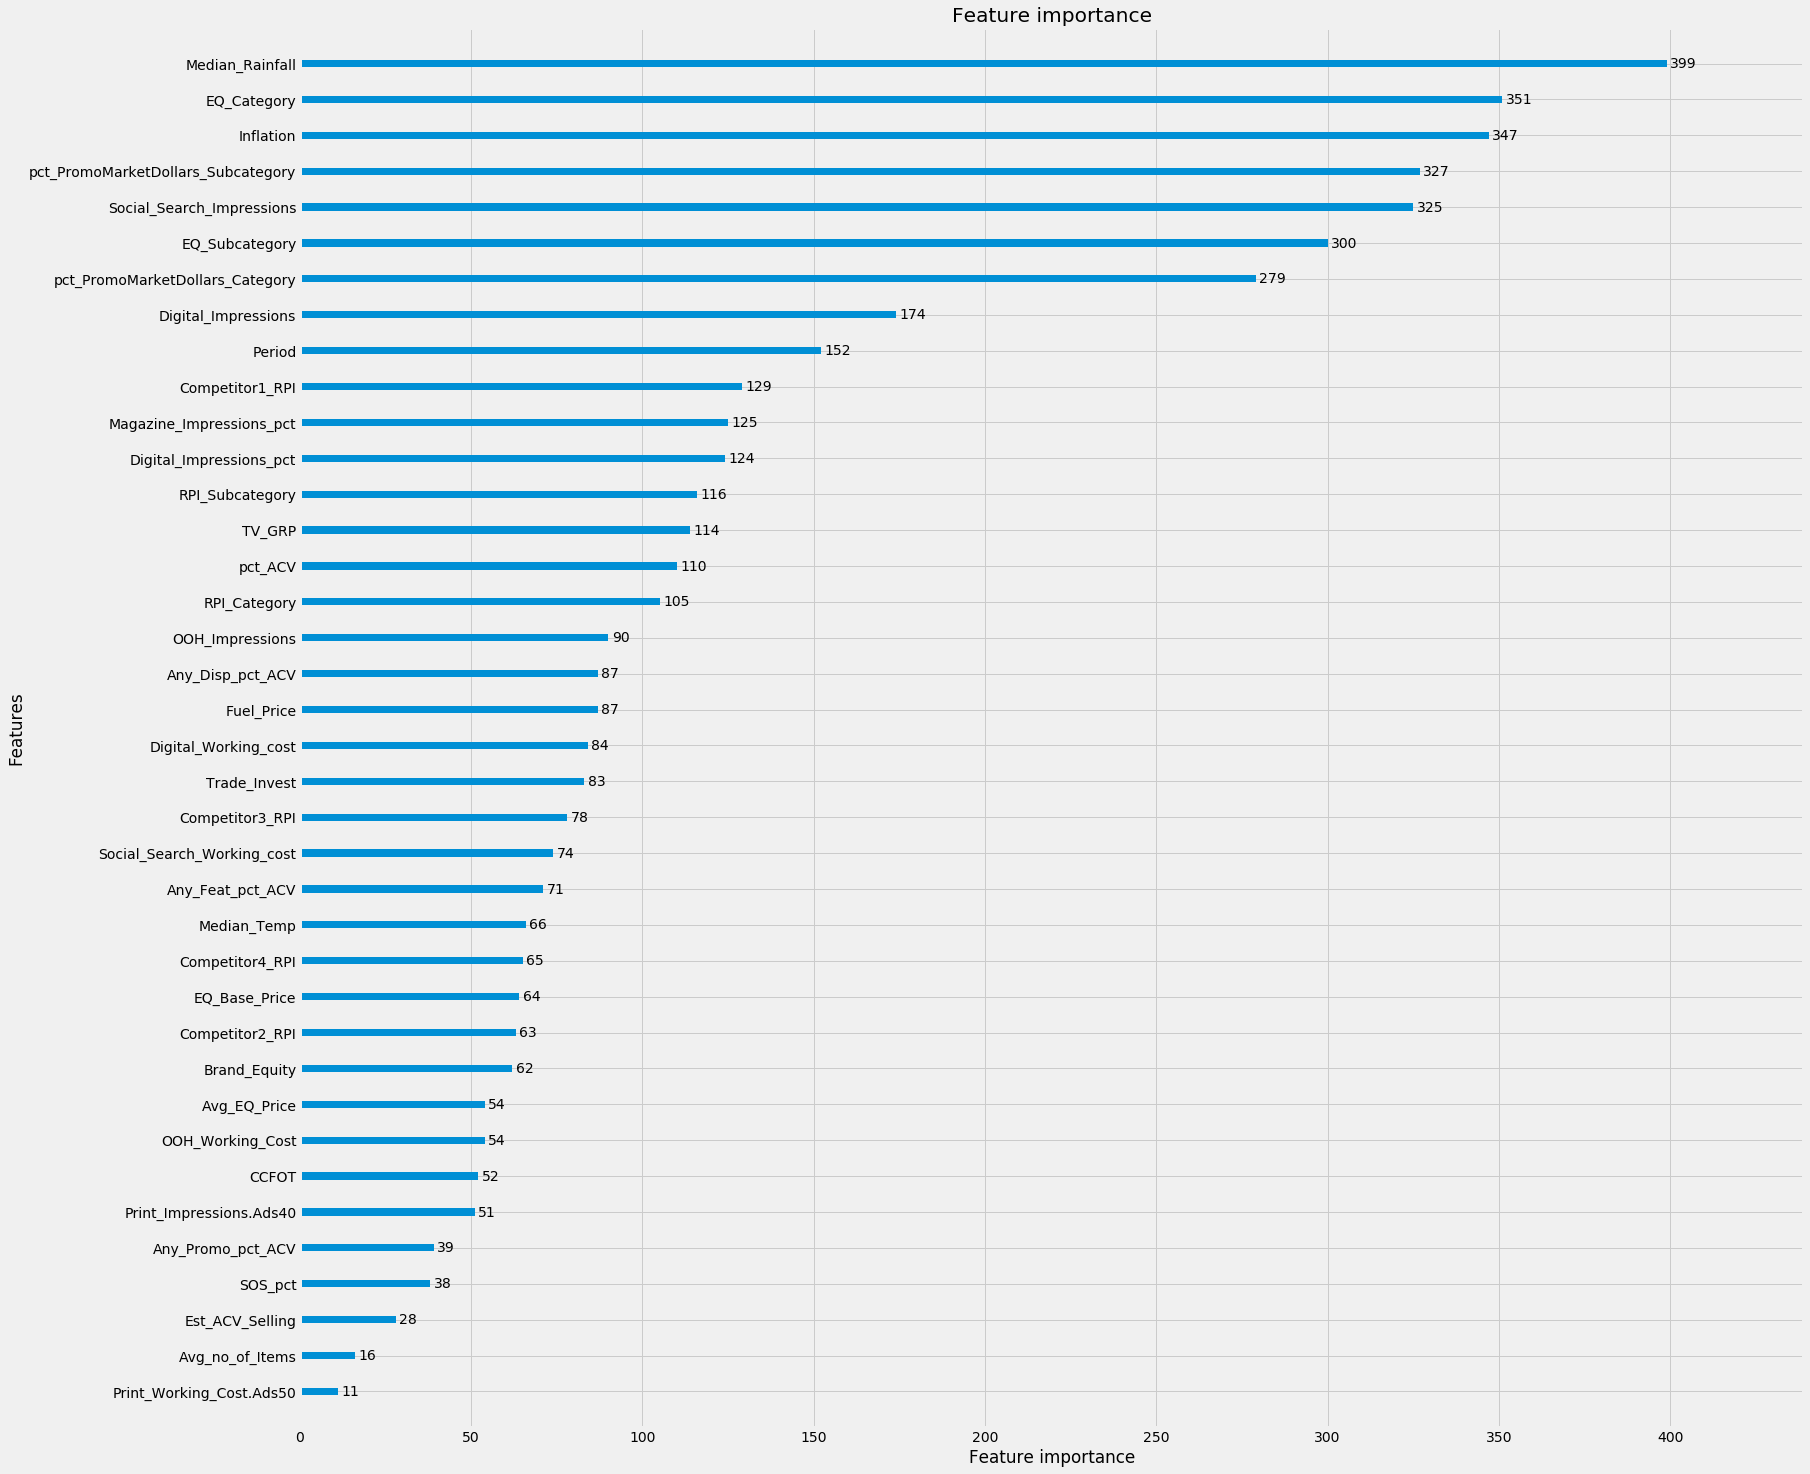

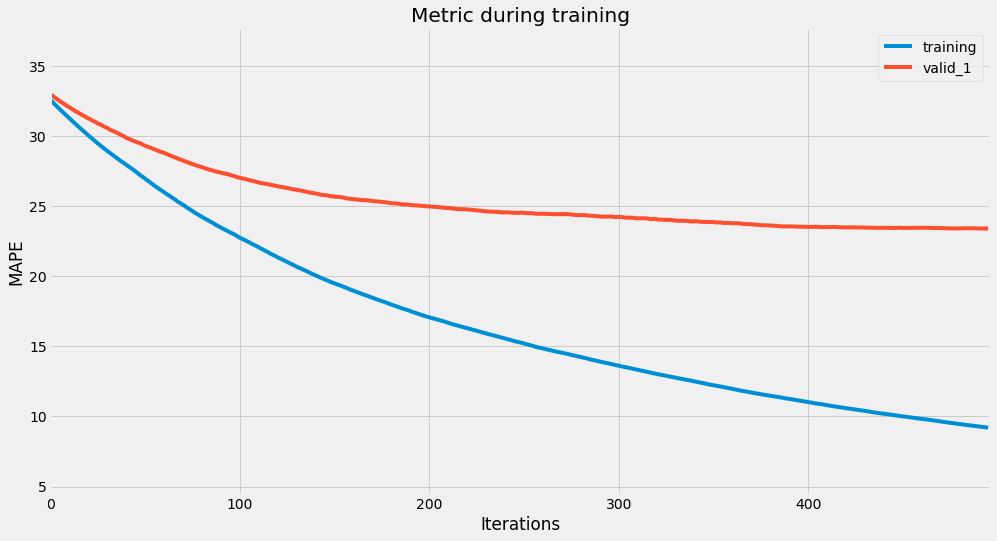

In [32]:
lgbM, best_score = lgb_model(train, feat, target)

In [33]:
preds = lgbM.predict(test[feat])
score = mape(test[target], preds)
score

78.67260006242824

## XGB Model

In [34]:
def mape_xgb(y_pred, dtrain):
    y_true = dtrain.get_label()
    score = mape(y_true, y_pred)

    return 'MAPE', score

def xgb_model(train, test, feat, target, ts=True):

    MAX_ROUNDS=2000
    early_stopping_rounds=50
    params = {
        'booster': 'gbtree', # dart
        'objective': 'reg:squarederror',
        'learning_rate': 0.06,
        'num_round': MAX_ROUNDS,
        'max_depth': 6,
        'seed': 13,
        'nthread': -1
    }
    if ts:
        X_train, X_valid, y_train, y_valid = train_test_split(train[feat], train[target], test_size=0.2, shuffle=False,
                                                              random_state=13)
    else:
        X_train, X_valid, y_train, y_valid = train_test_split(train[feat], train[target], test_size=0.2, random_state=13)

    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

    model = xgb.train(
        params,
        dtrain,
        evals=watchlist,
        num_boost_round=MAX_ROUNDS,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=50,
        feval = mape_xgb,
        maximize=False,
    )
    print("Best Iteration :: ", model.best_iteration)

    # Plotting Importances
    fig, ax = plt.subplots(figsize=(24, 24))
    xgb.plot_importance(model, height=0.4, ax=ax)
    preds = model.predict(xgb.DMatrix(test[feat]), ntree_limit=model.best_ntree_limit)
    print("TEST MAPE : {}".format(mape(test[target], preds)))
    
    return model, preds

(343, 38) (86, 38) (343,) (86,)
[19:14:44] WARNING: /workspace/src/learner.cc:328: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:641.49676	valid-rmse:642.02020	train-MAPE:93.83854	valid-MAPE:93.48503
Multiple eval metrics have been passed: 'valid-MAPE' will be used for early stopping.

Will train until valid-MAPE hasn't improved in 50 rounds.
[50]	train-rmse:59.95311	valid-rmse:185.07108	train-MAPE:6.10586	valid-MAPE:20.18719
Stopping. Best iteration:
[47]	train-rmse:66.92896	valid-rmse:186.81483	train-MAPE:6.71017	valid-MAPE:20.16302

Best Iteration ::  47
TEST MAPE : 35.696279734541584


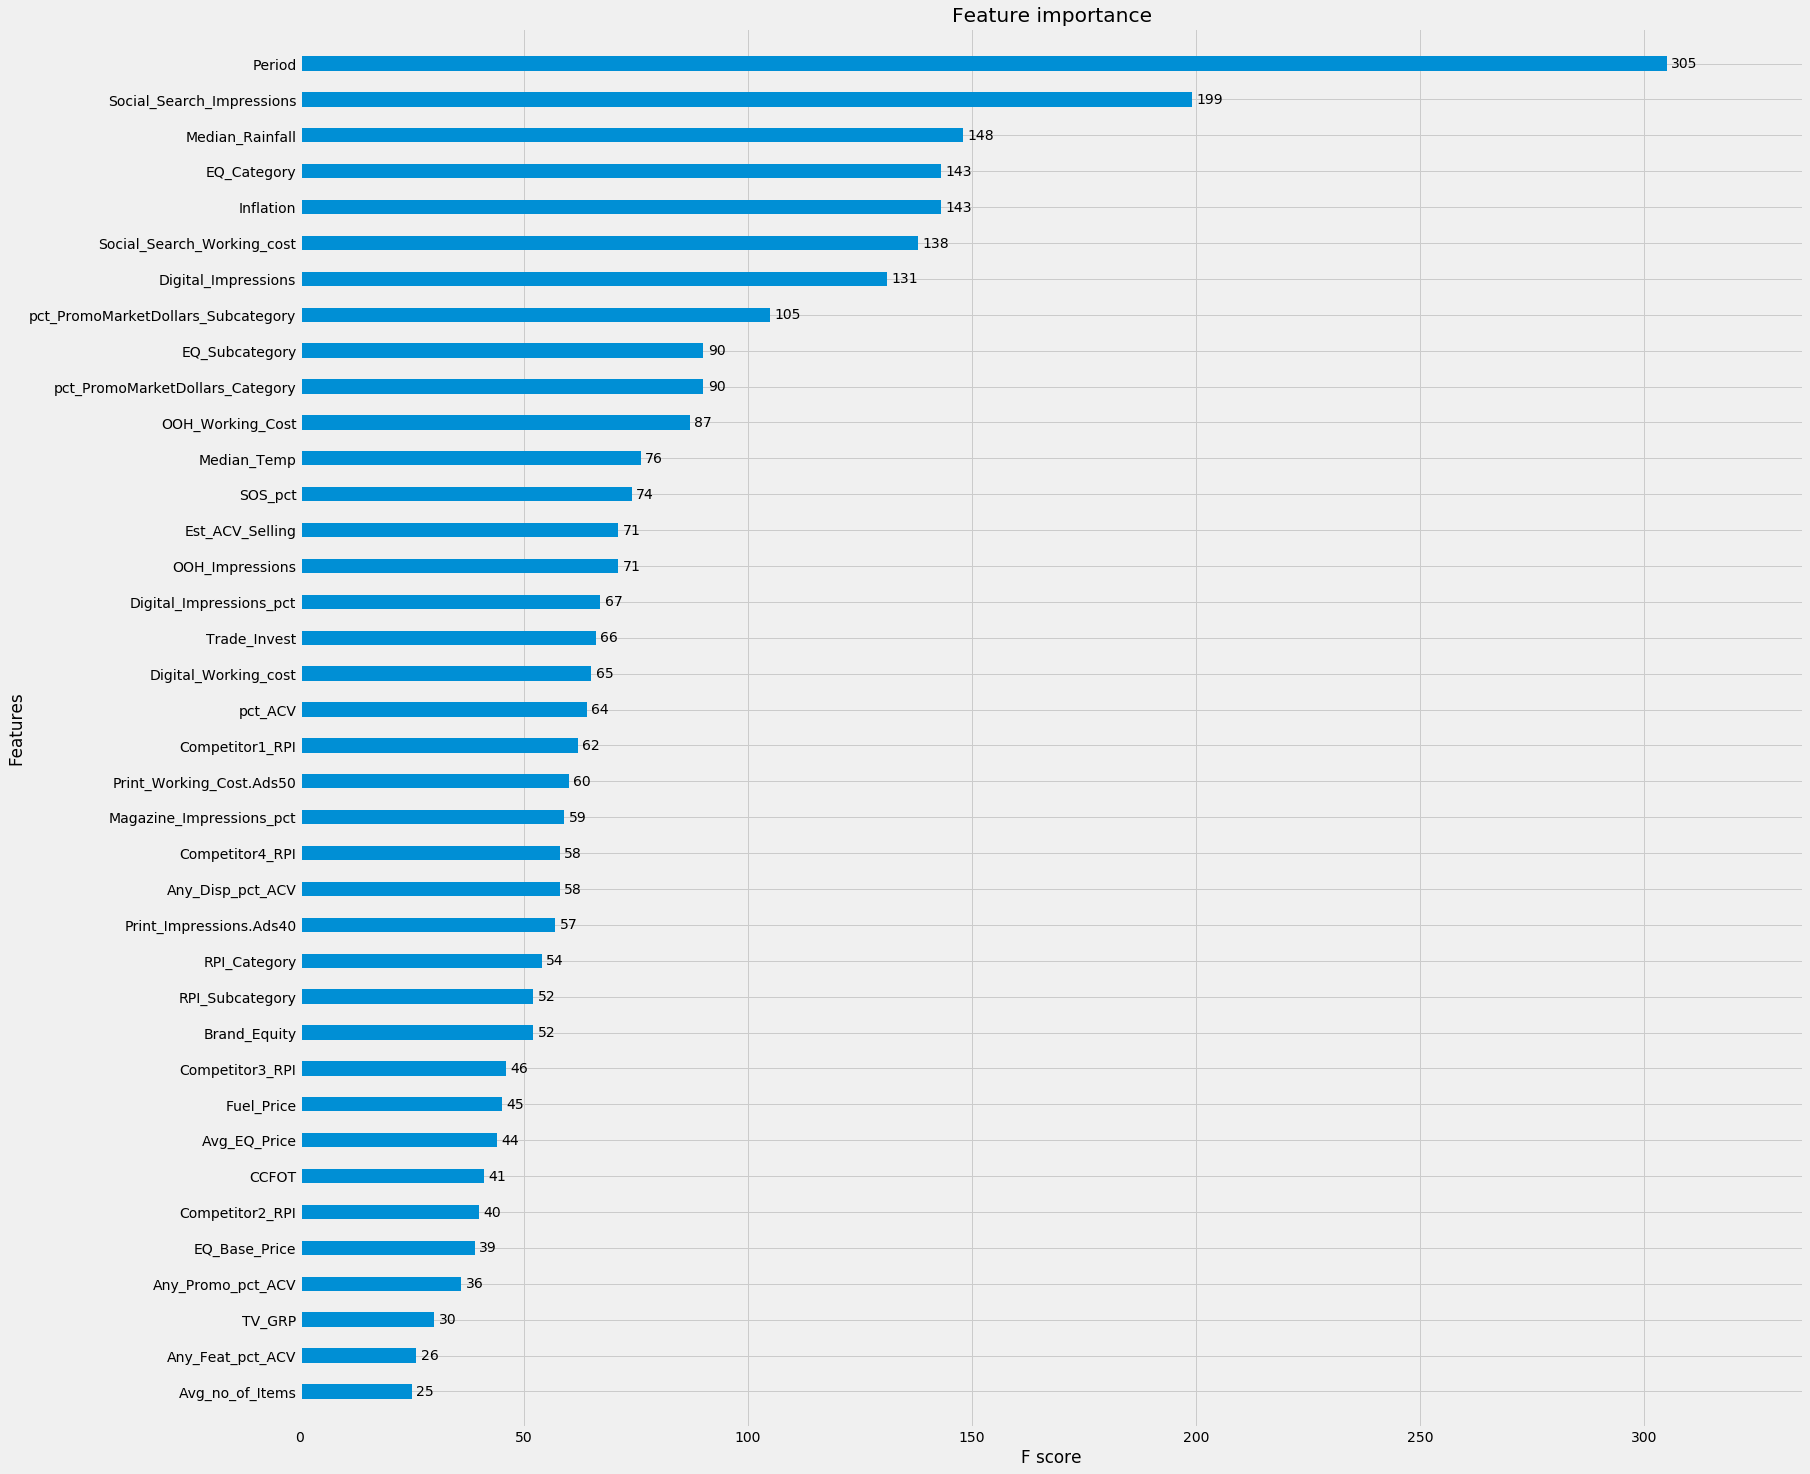

In [35]:
xgbM, xgb_preds = xgb_model(train, test, feat, target, ts=True)

In [36]:
test_mape = mape(test[target], xgb_preds)
test_mape

35.696279734541584

# Accuracy/Mape of Test Dataset
### TEST MAPE of 35.696279734541584 using XGB.

## Major Divers of the EQ Sales by Considering the PeriodWise Data

1. Period
2. Social_Search_Impressions
3. Median_Rainfall
4. EQ_Category
5. Inflation
6. Social_Search_Working_cost
7. Digital_Impressions
8. pct_PromoMarketDollars_Subcategory
9. EQ_Subcategory
10. pct_PromoMarketDollars_Category
 	

The feature importance of the above **10 features** is **high** compared to the rest of the features.

# Dataset-2 which contain:
1. Less amount of Data.
2. Missing Data

In [42]:
# Import the Dataset
train_2 = pd.read_csv("data/train_2.csv")
test_2 = pd.read_csv("data/test_2.csv")

train_2.shape, test_2.shape

((34, 39), (5, 39))

In [43]:
# Function for filling missing values
def missing_values(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    return mis_val_table_ren_columns

In [44]:
# Calculating the missing values % in train data
miss_train_2 = missing_values(train_2)
miss_train_2_columns = miss_train_2.index.tolist()
miss_train_2

Your selected dataframe has 39 columns.
There are 13 columns that have missing values.


,Missing Values,% of Total Values
OOH_Working_Cost,27,79.4
OOH_Impressions,24,70.6
Digital_Impressions_pct,24,70.6
Any_Feat_pct_ACV,23,67.6
Magazine_Impressions_pct,22,64.7
TV_GRP,22,64.7
Any_Disp_pct_ACV,12,35.3
Digital_Impressions,11,32.4
Digital_Working_cost,11,32.4
Social_Search_Impressions,10,29.4


In [45]:
# Calculating the missing values % in test data
missing_values(test_2)

Your selected dataframe has 39 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
Any_Feat_pct_ACV,4,80.0
Magazine_Impressions_pct,4,80.0
TV_GRP,4,80.0
Digital_Working_cost,3,60.0
OOH_Impressions,3,60.0
OOH_Working_Cost,3,60.0
Digital_Impressions,2,40.0
Digital_Impressions_pct,2,40.0
Any_Disp_pct_ACV,2,40.0


In [46]:
# Funcitons to fill the missing values
def get_isnull_features(train, test, null_cols):
    for col in null_cols:
        train['isnull_' + col] = train[col].isnull().map({True: 1, False: 0})
        test['isnull_' + col] = test[col].isnull().map({True: 1, False: 0})

    return train, test

def basic_null_treatment(orig_train, orig_test, cat_cols=None, num_cols=None, cat_treatment="Null", num_treatment="Mean"):
    train = orig_train.copy()
    test = orig_test.copy()
    
    print("Filling Null with 'Null' value")
    null_cols = list(set(
        train.columns[train.isnull().any()].tolist() + test.columns[test.isnull().any()].tolist()))

#     train, test = get_isnull_features(train, test, null_cols)
#     if not cat_cols or num_cols or cat_treatment or num_treatment:
#         for col in null_cols:
#             train[col].fillna(-1, inplace=True)
#             test[col].fillna(-1, inplace=True)
#     else:
    # Categorical Columns
#     for col in cat_cols:
#         if cat_treatment == "Null":
#             train[col].fillna("Null", inplace=True)
#             test[col].fillna("Null", inplace=True)
    # Numerical Columns
    for col in num_cols:
        if num_treatment == "Null":
            train[col].fillna("Null", inplace=True)
            test[col].fillna("Null", inplace=True)
        elif num_treatment == "Mean":
            train[col].fillna(train[col][~train[col].isnull()].mean(), inplace=True)
            test[col].fillna(test[col][~test[col].isnull()].mean(), inplace=True)
        elif num_treatment == "Mode":
            train[col].fillna(train[col].mode()[0], inplace=True)
            test[col].fillna(test[col].mode()[0], inplace=True)
        elif num_treatment == "-1":
            train[col].fillna("-1", inplace=True)
            test[col].fillna("-1", inplace=True)

    print("Total Null\nTrain : {}\nTest : {}".format(train.isnull().sum().sum(), test.isnull().sum().sum()))

    return train, test

In [47]:
train_2_filled, test_2_filled = basic_null_treatment(train_2, test_2, cat_cols=None, num_cols=miss_train_2_columns, cat_treatment="Null", num_treatment="Mean")

Filling Null with 'Null' value
Total Null
Train : 0
Test : 0


In [48]:
# Check the missing values % after filling the missing values in train dataset
missing_values(train_2_filled)

Your selected dataframe has 39 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [49]:
# Check the missing values % after filling the missing values in test dataset
missing_values(test_2_filled)

Your selected dataframe has 39 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [50]:
train_2_filled.head()

,Period,EQ,Social_Search_Impressions,Social_Search_Working_cost,Digital_Impressions,Digital_Working_cost,Print_Impressions.Ads40,Print_Working_Cost.Ads50,OOH_Impressions,OOH_Working_Cost,SOS_pct,Digital_Impressions_pct,CCFOT,Median_Temp,Median_Rainfall,Fuel_Price,Inflation,Trade_Invest,Brand_Equity,Avg_EQ_Price,Any_Promo_pct_ACV,Any_Feat_pct_ACV,Any_Disp_pct_ACV,EQ_Base_Price,Est_ACV_Selling,pct_ACV,Avg_no_of_Items,pct_PromoMarketDollars_Category,RPI_Category,Magazine_Impressions_pct,TV_GRP,Competitor1_RPI,Competitor2_RPI,Competitor3_RPI,Competitor4_RPI,EQ_Category,EQ_Subcategory,pct_PromoMarketDollars_Subcategory,RPI_Subcategory
0,2016 - Period:1,504.784933,1.229424e+07,51957.191257,37148.2,2045.282,2.008683e+06,32298.947990,9.930678e+08,3.202352e+06,7.446883,14.556558,100.0,32.950,0.5150,8.226,0.013258,42744.25684,42.410000,49.091447,9.691794,5.190196,1.688896,1.427532,8696587915,39.441025,2.611782,0.0339,35.817030,46.059377,32.008333,97.173365,35.557371,44.502717,63.377268,1728388.673,331927.5394,0.162732,40.560563
1,2016 - Period:2,490.226477,1.229424e+07,51957.191257,50886.8,2370.584,1.400000e-05,0.000015,9.930678e+08,3.202352e+06,11.677082,14.556558,87.5,34.625,0.2700,7.473,0.009938,36290.43956,42.410000,49.057612,9.415938,5.190196,1.687952,1.442716,8682307085,38.417224,2.522814,0.0391,36.389065,46.059377,32.008333,97.850760,37.223072,45.720077,62.731742,1900859.879,334611.3806,0.231650,40.046301
2,2016 - Period:3,479.244686,1.229424e+07,51957.191257,253333.2,3180.888,1.560000e-05,0.000017,9.930678e+08,3.202352e+06,0.102858,14.556558,96.0,46.700,0.3900,8.001,0.007832,34852.14166,42.410000,49.367514,5.176684,5.190196,1.666359,1.423408,8706897549,36.499442,2.477322,0.0228,36.599984,46.059377,32.008333,96.397739,40.800563,41.822953,62.090417,2036436.906,387148.3582,0.125394,40.411115
3,2016 - Period:4,489.057428,1.229424e+07,51957.191257,3426239.0,13595.398,1.624000e-05,0.000019,9.930678e+08,3.202352e+06,0.249055,14.556558,100.0,49.650,0.3500,8.767,0.010034,24869.55899,43.543571,50.657634,6.088273,5.190196,1.666359,1.443401,8660288592,38.135159,2.520409,0.0147,38.201852,46.059377,32.008333,98.936519,36.576140,41.578429,63.374358,2113635.013,482489.6740,0.056603,42.213246
4,2016 - Period:5,477.031994,1.229424e+07,51957.191257,552197.8,3983.134,1.649600e-05,0.000019,9.930678e+08,3.202352e+06,13.338804,14.556558,100.0,58.100,0.5025,9.277,0.009546,61675.32162,43.790000,50.625777,7.827112,5.190196,0.170731,1.473687,8644518558,38.629564,2.497285,0.0219,38.648805,31.702433,25.300000,100.509969,36.032016,42.602412,63.291934,2402211.102,629826.6484,0.065059,43.345578


In [51]:
# Convert the Period into int feature
def convert_period(X):
    year = int(X.split("-")[0].strip())
    period_num = int(X.split(":")[1].strip())
    
    if year == 2016:
        threshold = 0
    elif year == 2017:
        threshold = 13
    elif year == 2018:
        threshold = 26
    
    return period_num + threshold

In [52]:
# Conversion of train and test data
train_2_filled['Period'] = train_2_filled['Period'].apply(convert_period)
test_2_filled['Period'] = test_2_filled['Period'].apply(convert_period)

## Features

In [53]:
target = 'EQ'
feat = train_2_filled.columns.tolist()
feat.remove(target)

len(feat)

38

In [54]:
# Applying the baseliner models on the dataset
baseliner(train_2_filled, feat, target)

sklearn Model Name  	  CV
----------------------------------------------------------------------------------------------------
LGBMRegressor 	 -52.2228 	
XGBRegressor 	 -33.2041 	
GradientBoostingRegre 	 -49.1338 	
RandomForestRegressor 	 -45.6192 	
LinearRegression 	 -48.8656 	
DecisionTreeRegressor 	 -47.7900 	
ExtraTreeRegressor 	 -48.4459 	
AdaBoostRegressor 	 -44.7638 	
BaggingRegressor 	 -41.9039 	
ExtraTreesRegressor 	 -38.0187 	
ElasticNet 	 -42.3501 	
Lasso 	 -34.2594 	
Ridge 	 -67.9860 	
SVR 	 -50.2253 	
KNeighborsRegressor 	 -33.9280 	


LGB Model
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's l2: 152988	training's MAPE: 120.299	valid_1's l2: 294701	valid_1's MAPE: 278.448


49.986379749585616

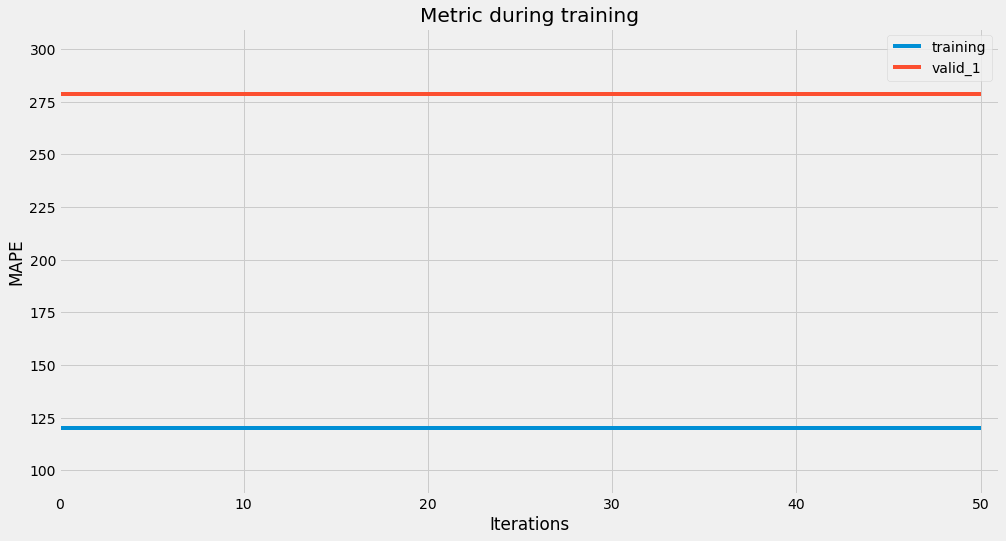

In [57]:
# Apply LGB Model
lgbM, best_score = lgb_model(train_2_filled, feat, target)
preds = lgbM.predict(test_2_filled[feat])
score = mape(test_2_filled[target], preds)
score

## Apply XGB Model

(27, 38) (7, 38) (27,) (7,)
[19:19:52] WARNING: /workspace/src/learner.cc:328: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:351.88138	valid-rmse:186.52458	train-MAPE:94.02598	valid-MAPE:88.35968
Multiple eval metrics have been passed: 'valid-MAPE' will be used for early stopping.

Will train until valid-MAPE hasn't improved in 50 rounds.
[50]	train-rmse:25.68406	valid-rmse:54.74169	train-MAPE:5.56144	valid-MAPE:26.57574
Stopping. Best iteration:
[26]	train-rmse:85.00432	valid-rmse:52.11044	train-MAPE:21.14393	valid-MAPE:22.67326

Best Iteration ::  26
TEST MAPE : 19.76732474859598


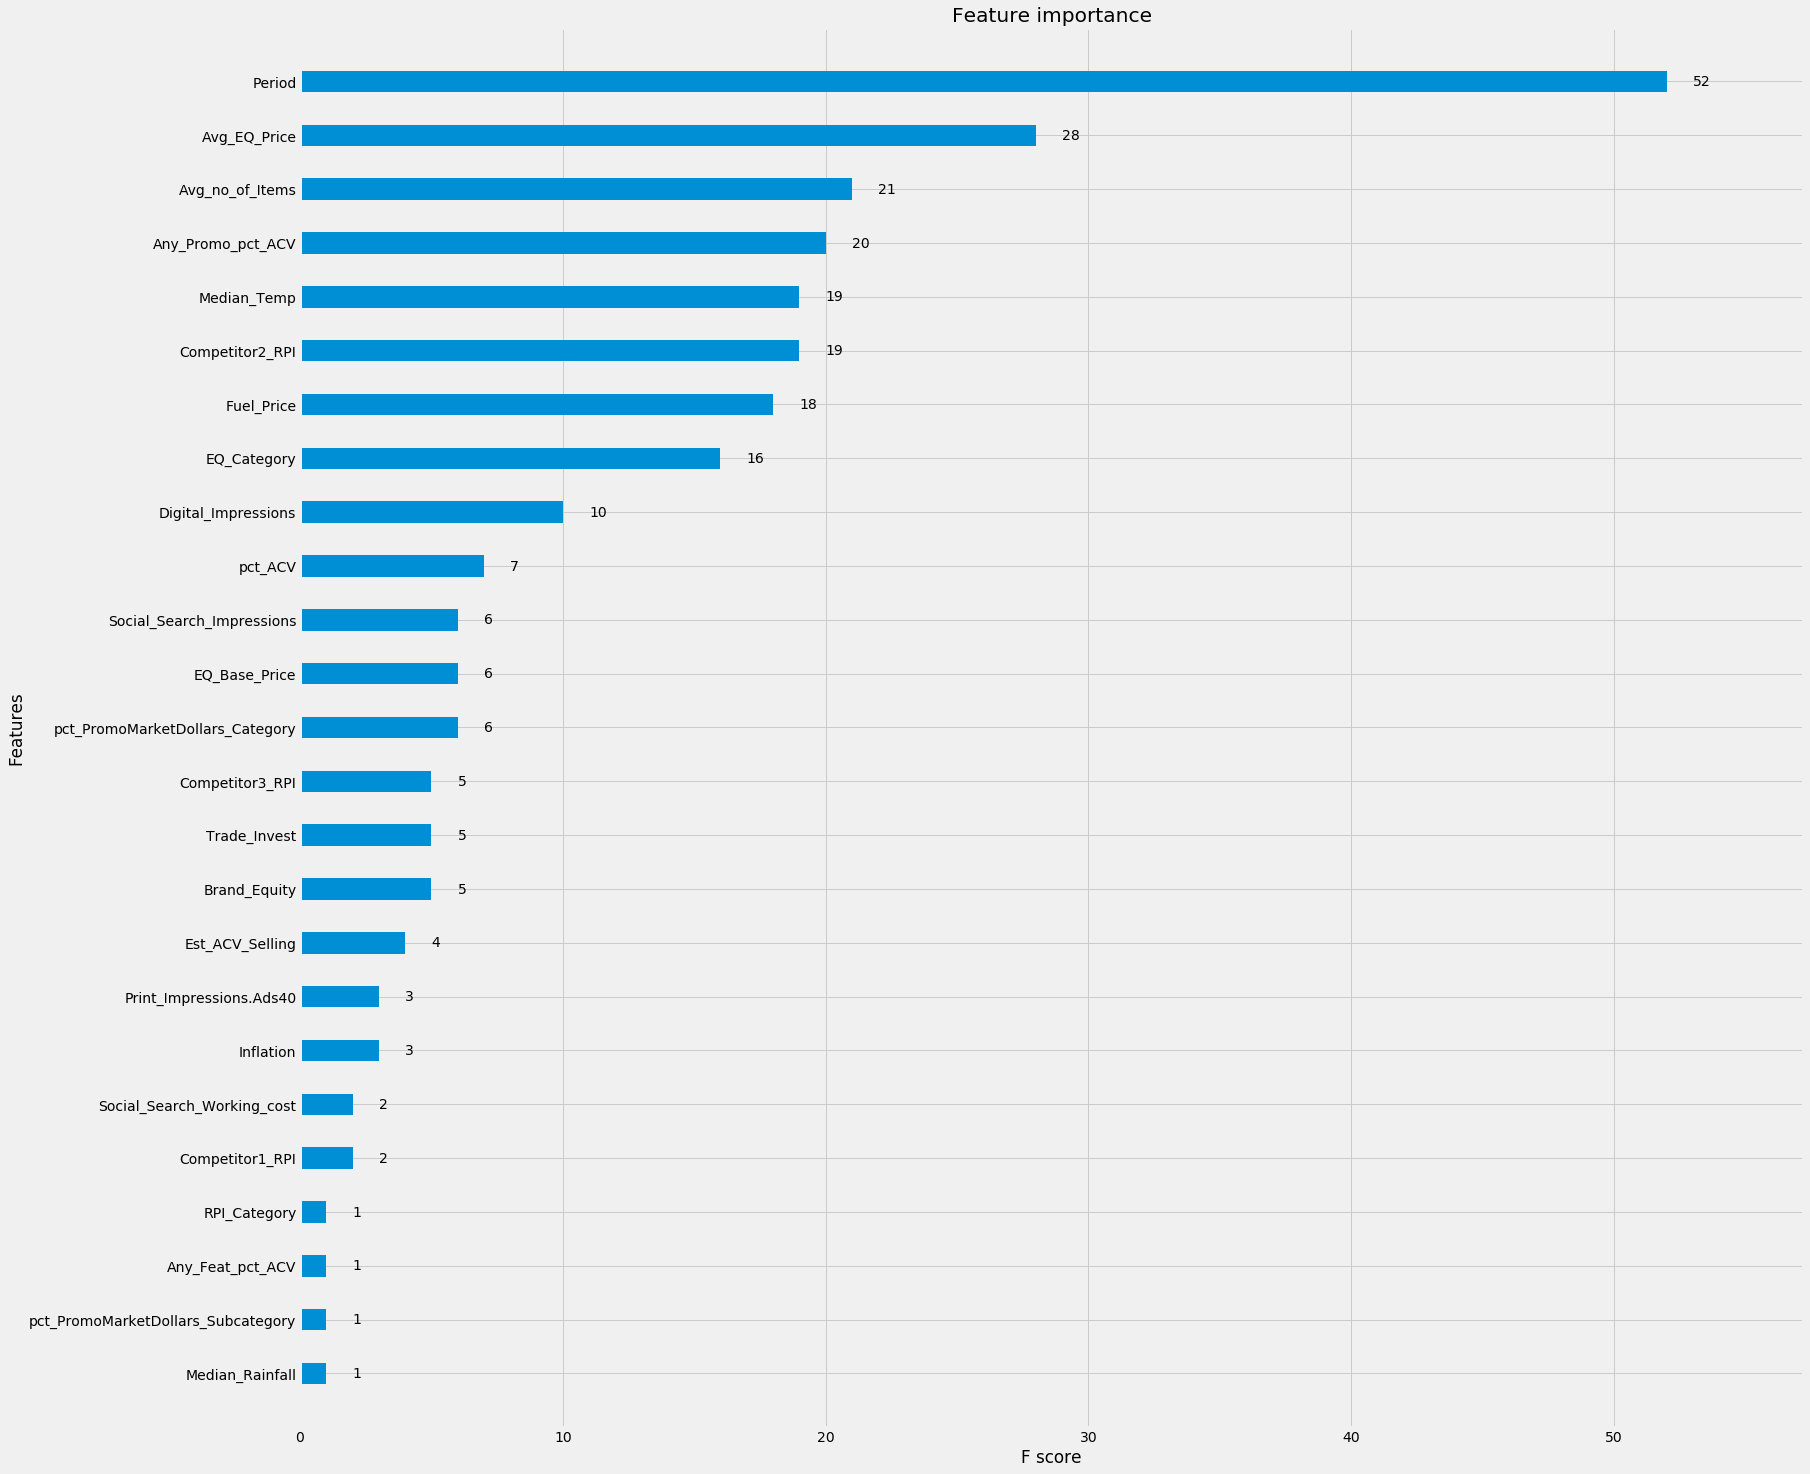

In [58]:
xgbM, xgb_preds = xgb_model(train_2_filled, test_2_filled, feat, target, ts=True)

# Accuracy/Mape of Test Dataset
## TEST MAPE : 19.76732474859598